In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
X_digits, y_digits = load_digits(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X_digits,y_digits)




In [3]:
#Need to scale the data for Logistic Regression otherwise it won't converge
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
X_train[0]

array([ 0.,  0.,  0.,  4., 15.,  6.,  0.,  0.,  0.,  0.,  0., 13., 13.,
        1.,  0.,  0.,  0.,  0.,  7., 16.,  2.,  0.,  0.,  0.,  0.,  4.,
       15.,  8.,  0.,  5.,  0.,  0.,  0., 11., 14.,  1.,  6., 16.,  5.,
        0.,  1., 16., 14., 12., 16., 16.,  3.,  0.,  0., 10., 12., 10.,
       16., 10.,  0.,  0.,  0.,  0.,  0.,  6., 16.,  2.,  0.,  0.])

In [27]:
X_train_scaled[0]

array([ 0.        , -0.35530978, -1.10813628, -1.94267032,  0.73889945,
        0.05167137, -0.40183839, -0.12249676, -0.05760195, -0.63272168,
       -1.99555289,  0.24819837,  0.58240087, -1.1856311 , -0.51261039,
       -0.12400944, -0.04453802, -0.72663898, -0.50824588,  1.58623486,
       -0.80979601, -1.25070269, -0.55316874, -0.11208582, -0.03856149,
        0.49317659,  0.97114649, -0.13808323, -1.60435961, -0.4223247 ,
       -0.61872863, -0.02725696,  0.        ,  2.49504273,  0.99680246,
       -1.29805404, -0.72501235,  1.22258731,  0.59568028,  0.        ,
        6.3393133 ,  4.95947298,  1.0612487 ,  0.75270657,  1.35415583,
        1.3494101 , -0.12205756, -0.09334883, -0.03856149,  5.41465192,
        0.78434186,  0.09095421,  1.27619782,  0.18794902, -0.76646078,
       -0.21377744,  0.        , -0.32263582, -1.09982558, -1.47623864,
        0.8502854 , -0.81233275, -0.50734698, -0.19260118])

In [25]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train,y_train)

log_reg.score(X_test,y_test)

0.9555555555555556

In [28]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_scaled,y_train)

log_reg.score(X_test_scaled,y_test)

0.9555555555555556

### Now try using KMeans for feature engineering
* Cluster the data
* Represent each instance by the distance from the centroid

In [29]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pl_kmeans = Pipeline([
    ("cluster",KMeans()), 
    ("log_reg",LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
    )])

param_grid = dict(cluster__n_clusters=range(2,200,2))

grid_km_clf = GridSearchCV(pl_kmeans,param_grid,cv=3,verbose=2,n_jobs=6)

grid_km_clf.fit(X_train,y_train)


Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cluster', KMeans()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=6, param_grid={'cluster__n_clusters': range(2, 200, 2)},
             verbose=2)

In [32]:
#Above outputs cleared because LogisticRegression constantly fails because of lack of scaling

print(grid_km_clf.best_score_)
print(grid_km_clf.best_params_)
grid_km_clf.score(X_test,y_test)

0.9836674090571641
{'cluster__n_clusters': 162}


0.9622222222222222

In [40]:
error_reduction = -((1-grid_km_clf.score(X_test,y_test)-(1-log_reg.score(X_test_scaled,y_test)))/(1-log_reg.score(X_test_scaled,y_test)))
print (f"Reduction in error rate from adding Kmeans (no subsequent scaling) {error_reduction:.2%}")


Reduction in error rate from adding Kmeans (no subsequent scaling) 15.00%


In [48]:
#Now try scaling the output from KMeans
pl_kmeans_scaled = Pipeline([
    ("cluster",KMeans(n_init=40)), 
    ("scaler",StandardScaler()),
    ("log_reg",LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
    ])

param_grid = dict(cluster__n_clusters=range(2,200,2))

grid_km_scaled_clf = GridSearchCV(pl_kmeans_scaled,param_grid,cv=3,verbose=2,n_jobs=6)
#Not using scaled data as will be scaling after the kmeans step
grid_km_scaled_clf.fit(X_train,y_train)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cluster', KMeans(n_init=40)),
                                       ('scaler', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=6, param_grid={'cluster__n_clusters': range(2, 200, 2)},
             verbose=2)

In [49]:
print(grid_km_scaled_clf.best_score_)
print(grid_km_scaled_clf.best_params_)
grid_km_scaled_clf.score(X_test,y_test)

0.9821826280623608
{'cluster__n_clusters': 152}


0.9622222222222222

* Scaling speeds convergence of Logistic Regression
* no evidence of non-convergence from unscaled - just takes roughly 4 times longer
* Using these extra cycles to enhance quality of the clustering algorithm (by increasing the number of initial centroids used):
    * little benefit observed


Kmeans clustering pre-processing does not improve
* raw RFC gets 96.89% 
* k means gets 96.67%

In [102]:
from sklearn.ensemble import RandomForestClassifier

clf_RFC = RandomForestClassifier(random_state=42,n_estimators=1000)

clf_RFC.fit(X_train,y_train)
print(f"Raw RFC performance {clf_RFC.score(X_test,y_test):.2%}")

Raw RFC performance 96.89%


In [107]:
rfc_score=[]
for clusters in range(2,200,2):
    KM = KMeans(n_clusters=clusters).fit(X_train,y_train)
    X_Kmeans = KM.transform(X_train) #X_means is now cluster distances
    rfc = RandomForestClassifier(random_state=42,n_estimators=1000)
    rfc.fit(X_Kmeans,y_train)
    x_test_Kmeans = KM.transform(X_test)
    rfc_score.append(rfc.score(x_test_Kmeans,y_test))

print(f"Max Kmeans RFC performance {max(rfc_score):.2%}")

Max Kmeans RFC performance 96.22%


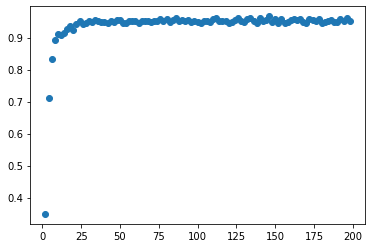

Max Kmeans RFC performance 96.67%


In [104]:
import matplotlib.pyplot as plt

plt.scatter(range(2,200,2),rfc_score)
plt.show()

print(f"Max Kmeans RFC performance {max(rfc_score):.2%}")